# Prerequisites

In order to build Try .NET, you'll need the following installed:

* The [.NET 9 SDK](https://learn.microsoft.com/en-us/dotnet/core/install/).
* The LTS version of [Node.js](https://nodejs.org/en/download).

# 1: [Optional] Build .NET Interactive

The core functionality in Try .NET is the .NET Interactive repo, which contains the `CSharpProjectKernel` that powers Try .NET's compilation and language services. 

* If you're making changes in that layer, then you'll need to build the .NET Interactive packages locally. 

* If not, skip to step 2.1.

## 1.1: Clone, build, and pack .NET Interactive

First, make sure you have the [.NET Interactive repo](https://github.com/dotnet/interactive) forked and cloned. Set the path to the repo root in the following cell. 


In [ ]:
$dotnetInteractiveRepoPath = Read-Host -Prompt "Enter the path to the root of your dotnet/interactive clone"
$dotnetInteractiveRepoPath

Follow the instructions to build .NET Interactive in the [developer guide](https://github.com/dotnet/interactive/blob/main/DEVELOPER-GUIDE.md). 

You don't need to set up a local build of the Polyglot Notebooks extension to work on Try .NET.

The following script will build the project and copy the generated packages to C:\temp\packages\ which will be be used a NuGet package source when building Try .NET.

In [ ]:
Invoke-Expression "$dotnetInteractiveRepoPath\repack.ps1"

## 1.2: Update Microsoft.DotNet.Interactive.CSharpProject version used by Try .NET

This step only needs to be done if you're changing code from the .NET Interactive repo.

This step modifies NuGet.config to reference the local package source where .NET Interactive packages build in Step 1.* should be found.

In [ ]:
$tryDotnetRepoPath = Get-Location

$nugetConfigPath = Join-Path $tryDotnetRepoPath 'NuGet.config'
[xml]$nugetConfig = Get-Content $nugetConfigPath

$newPackageSource = $nugetConfig.CreateElement("add")
$newPackageSource.SetAttribute("key", "LocalDevPackages")
$newPackageSource.SetAttribute("value", "C:\temp\packages")

$packageSourcesNode = $nugetConfig.SelectSingleNode('configuration/packageSources')
$packageSourcesNode.AppendChild($newPackageSource) > $null

$packageMappingNode = $nugetConfig.CreateElement("packageSource")
$packageMappingNode.SetAttribute("key", "LocalDevPackages")
$packageNode = $nugetConfig.CreateElement("package")
$packageNode.SetAttribute("pattern", "*")
$packageMappingNode.AppendChild($packageNode) > $null

$packageSourcesNode = $nugetConfig.SelectSingleNode('configuration/packageSourceMapping')
$packageSourcesNode.AppendChild($packageMappingNode) > $null

$nugetConfig.Save($nugetConfigPath)

Next, update the referenced version of the package.

In [ ]:
# Define the path to the Directory.Packages.props file
$packagesPropsPath = "$tryDotnetRepoPath\Directory.Packages.props"

# Load the XML content of the Directory.Packages.props file
[xml]$packagesProps = Get-Content $packagesPropsPath

# Define the namespace to handle the default namespace in the document
$namespaceManager = New-Object System.Xml.XmlNamespaceManager($packagesProps.NameTable)
$namespaceManager.AddNamespace("msb", "http://schemas.microsoft.com/developer/msbuild/2003")

# Ensure that the ItemGroup element exists
$itemGroup = $packagesProps.SelectSingleNode("msb:Project/msb:ItemGroup", $namespaceManager)
if ($itemGroup -eq $null) {
    $itemGroup = $packagesProps.CreateElement("ItemGroup", $namespaceManager.LookupNamespace("msb"))
    $packagesProps.DocumentElement.AppendChild($itemGroup)
}

# Check if the PackageVersion element for the package already exists
$packageRef = $itemGroup.SelectSingleNode("msb:PackageVersion[@Include='Microsoft.DotNet.Interactive.CSharpProject']", $namespaceManager)

if ($packageRef -eq $null) {
    # If the package reference doesn't exist, create it
    $newPackageRef = $packagesProps.CreateElement("PackageVersion", $namespaceManager.LookupNamespace("msb"))
    $newPackageRef.SetAttribute("Include", "Microsoft.DotNet.Interactive.CSharpProject")
    $newPackageRef.SetAttribute("Version", "2.0.0")
    $itemGroup.AppendChild($newPackageRef)
} else {
    # If it exists, just update the version
    $packageRef.SetAttribute("Version", "2.0.0")
}

# Save the changes back to the Directory.Packages.props file
$packagesProps.Save($packagesPropsPath)


## 2.1: Build Try .NET

In [ ]:
$tryDotnetRepoPath = Get-Location

$tryDotNetProjectFilePath="$tryDotnetRepoPath\src\Microsoft.TryDotNet\Microsoft.TryDotNet.csproj"
$mockMsLearnServerPath="$tryDotnetRepoPath\src\microsoft-learn-mock"

First, build the client pieces, which includes the `trydotnet.js` library.

In [ ]:
if ($IsWindows) {
    Invoke-Expression "$tryDotnetRepoPath\build-js.cmd"
} else {
    Invoke-Expression "$tryDotnetRepoPath/build-js.sh"
}

Next, build the Try .NET service.

In [ ]:
dotnet build -c Debug $tryDotnetRepoPath

## 2.2: Start the Try .NET service

This launches the Try .NET web service. It will launch in a separate terminal window. Closing that window will stop the server.

In [ ]:
Start-Process pwsh -ArgumentList "-c dotnet run --no-build --project ${tryDotNetProjectFilePath} --launch-profile TryDotNet-Development"

* _Note: If the above crashes with an error that looks like the following, the issue is hardcoded paths in the `Prebuild` folder. If you delete them, they will be regenerated on startup._

    ```console
    Logging to: c:\temp
    Unhandled exception. System.IO.FileNotFoundException: Could not find a part of the path 'C:\Program Files\dotnet\packs\Microsoft.NETCore.App.Ref\8.0.8\ref\net8.0\Microsoft.CSharp.dll'.
    File name: 'C:\Program Files\dotnet\packs\Microsoft.NETCore.App.Ref\8.0.8\ref\net8.0\Microsoft.CSharp.dll'
    ---> System.IO.DirectoryNotFoundException: Could not find a part of the path 'C:\Program Files\dotnet\packs\Microsoft.NETCore.App.Ref\8.0.8\ref\net8.0\Microsoft.CSharp.dll'.
    ```

    _The following cell will tell you where the prebuilds are located on your machine. You can delete this directory entirely to allow the prebuilds to be rebuilt when the Try .NET service starts._

In [ ]:
using System.IO;

string PrebuildPathEnvironmentVariableName = "TRYDOTNET_PREBUILDS_PATH";

var environmentVariable = Environment.GetEnvironmentVariable(PrebuildPathEnvironmentVariableName);

var prebuildsLocation =
    environmentVariable is not null
        ? new DirectoryInfo(environmentVariable)
        : new DirectoryInfo(
            Path.Combine(
                Environment.GetFolderPath(Environment.SpecialFolder.UserProfile),
                ".trydotnet",
                "prebuilds"));

prebuildsLocation.ToString().Display();

// UNCOMMENT TO DELETE THIS FOLDER AND RESET
// prebuildsLocation.Delete(recursive: true);

## 2.3: Verify Try .NET by running Peaky tests

When the server is up and running, you should see something like this:

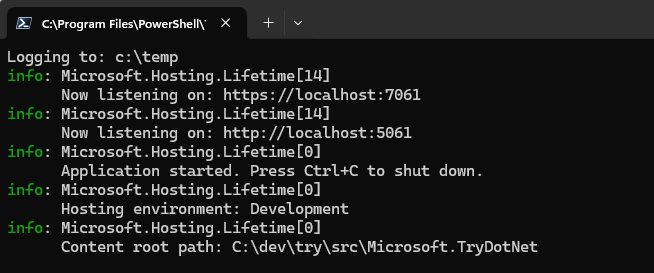

You can now verify basic (server-side) functionality by running the embedded [Peaky](https://github.com/PeakyTests/Peaky) tests.

In [ ]:
#r "nuget:Peaky.Client"

using Peaky.Client;
using System.Net.Http;

var peakyClient = new PeakyClient(new Uri("https://localhost:7061/tests"));

var tests = (await peakyClient.GetTestsAsync()).Where(t => t.Tags.Any(tag => tag is "self"));

foreach (var test in tests)
{
    var result = await test.GetResultAsync();
    result.Display();
}

## 2.4: Build the MS Learn mock server

In [ ]:
Set-Location -Path $mockMsLearnServerPath
npm ci
npm run buildProd
Set-Location $tryDotnetRepoPath

## 2.5: Launch the MS Learn mock server

This site hosts the Try .NET IFRAME and provides controls so you can see if things are working. It will launch in a separate terminal window. Closing that window will stop the server.

In [ ]:
Set-Location -Path $mockMsLearnServerPath

Start-Process pwsh -ArgumentList "-c npx http-server -p 7063"

Set-Location $tryDotnetRepoPath

## 2.6: Open the MS Learn mock site and interact with Try .NET

In [ ]:
Start-Process "http://127.0.0.1:7063/site/DocsHost.html?trydotnetUrl=https://localhost:7061/api/trydotnet.min.js&trydotnetOrigin=https://localhost:7061/"

## Try .NET / Microsoft Learn flow diagram

The diagram available through the link below provides a comprehensive view of the interaction between the Try .NET service and a host page (e.g., learn.microsoft.com).

https://github.com/dotnet/interactive/tree/main/src/Microsoft.DotNet.Interactive.CSharpProject#try-net--microsoft-learn-flow

The core of Try .NET is powered by the `CSharpProjectKernel`, which does most of the work powering the Try .NET service.